# Jupyter Notebook for Task 4: Modeling

## Preperation
Before we start modeling, we have to load the packages and the data, and prepare it so it can be processed by the models.

In [13]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# supress versioning warnings of keras
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import Sequential # sequential model: https://keras.io/guides/sequential_model/
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2

In [14]:
agg_charging_data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))
agg_charging_data['year'] = agg_charging_data.index.year
agg_charging_data = agg_charging_data[agg_charging_data['year'] == 2021]
agg_charging_data['week_of_year'] = agg_charging_data['week_of_year'].astype('int32')

agg_charging_data.info(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6152 entries, 2021-01-01 00:00:00-08:00 to 2021-09-14 08:00:00-07:00
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   activeSessions_site1     6152 non-null   int64  
 1   utilizationRate_site1    6152 non-null   float64
 2   kWhDelivered_site1       6152 non-null   float64
 3   idleRate_site1           6152 non-null   float64
 4   blockedRate_site1        6152 non-null   float64
 5   activeSessions_site2     6152 non-null   int64  
 6   utilizationRate_site2    6152 non-null   float64
 7   kWhDelivered_site2       6152 non-null   float64
 8   idleRate_site2           6152 non-null   float64
 9   blockedRate_site2        6152 non-null   float64
 10  activeSessions_total     6152 non-null   int64  
 11  kWhDelivered_total       6152 non-null   float64
 12  utilizationRate_total    6152 non-null   float64
 13  idleRate_total           6152 

In [38]:
#different data sets to train the models
gesamt_charging_data = agg_charging_data[['utilizationRate_total', 'hour_of_day', 'day_of_week', 'month_of_year', 'kWhDelivered_total', 'activeSessions_total']]

site1_charging_data = agg_charging_data[
    ['utilizationRate_site1', 'hour_of_day', 'day_of_week', 'month_of_year', 'kWhDelivered_site1',
     'activeSessions_site1']]

site2_charging_data = agg_charging_data[
    ['utilizationRate_site2', 'hour_of_day', 'day_of_week', 'month_of_year', 'kWhDelivered_site2',
     'activeSessions_site2']]

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Daten aufteilen
X = site2_charging_data[['hour_of_day', 'day_of_week', 'month_of_year']]
y = site2_charging_data['utilizationRate_site2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Daten skalieren
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modell erstellen
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)  # Für die Vorhersage eines kontinuierlichen Wertes
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Modell trainieren
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# Vorhersagen
y_pred_nn = model.predict(X_test)

Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0579 - val_loss: 0.0025 - val_mae: 0.0410
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0338e-04 - mae: 0.0192 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3532e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0272
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5930e-04 - mae: 0.0146 - val_loss: 0.0013 - val_mae: 0.0277
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3970e-04 - mae: 0.0140 - val_loss: 0.0013 - val_mae: 0.0268
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3562e-04 - mae: 0.0137 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 7/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1173e-04 - mae: 0.0132 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 8/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8507e-04 - mae: 0.0126 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 9/15
139/139 ━━━━━━━━━

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge


# D = 5 # degree of polynomials
# ALPHA = 0.1 # alpha (in lecture: lambda) for regularization penalty

# poly = Pipeline([
#     ('polynomials', PolynomialFeatures(degree = D)), 
#     ('ridge', Ridge(alpha = ALPHA))
# ])

# Polynomiale Features erstellen
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)

# Daten aufteilen
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.1, shuffle=False)

# Modell erstellen
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_poly)

# Vorhersagen
y_pred_poly = poly_model.predict(X_test_poly)

# Fehler berechnen
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
print(f"Mean Squared Error (Polynomial Regression): {mse_poly}")

AttributeError: This 'Pipeline' has no attribute 'fit_transform'

In [47]:
from sklearn.metrics import mean_absolute_error, r2_score

# Neuronales Netzwerk
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")

# Polynome Regression
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)

print(f"Polynomial Regression - MSE: {mse_poly}, MAE: {mae_poly}, R²: {r2_poly}")

Neural Network - MSE: 0.003337647058333059, MAE: 0.03995629490202576, R²: 0.4222439980502013
Polynomial Regression - MSE: 0.0017837030077206295, MAE: 0.030086355116803066, R²: 0.6912360413203207


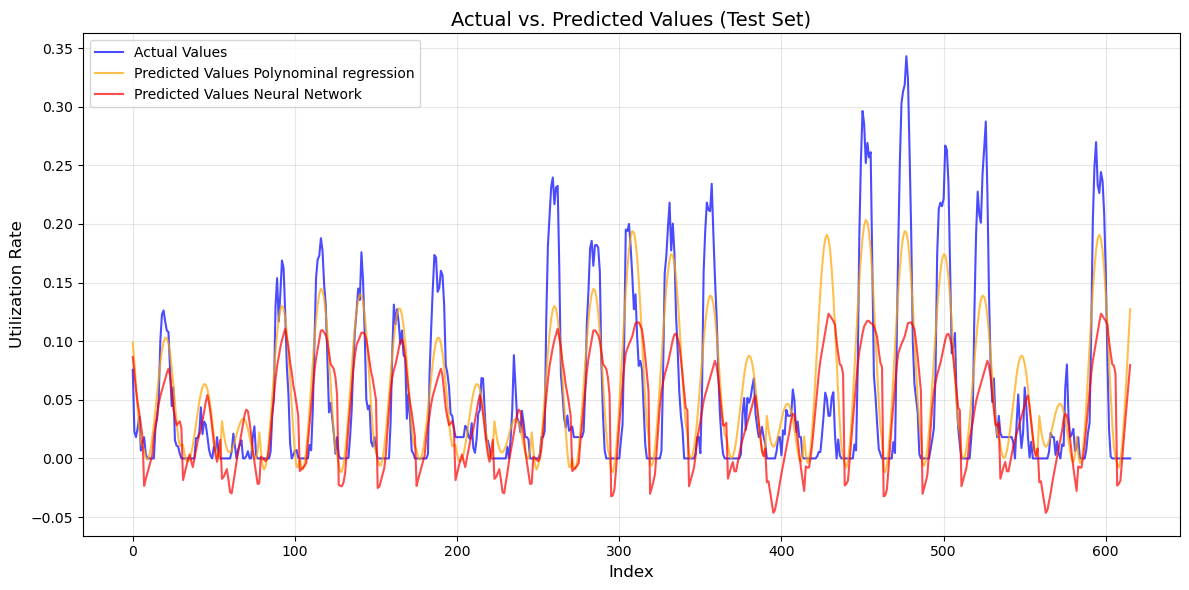

Neural Network - MSE: 0.003337647058333059, MAE: 0.03995629490202576, R²: 0.4222439980502013
Polynomial Regression - MSE: 0.0017837030077206295, MAE: 0.030086355116803066, R²: 0.6912360413203207


In [48]:
from sklearn.metrics import mean_absolute_error, r2_score

# Neuronales Netzwerk
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)


# Polynome Regression
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)


import matplotlib.pyplot as plt
import numpy as np

# Index erstellen, um die Testdaten in der Reihenfolge darzustellen
indices = np.arange(len(y_test_poly))

plt.figure(figsize=(12, 6))

# Tatsächliche Werte plotten
plt.plot(indices, y_test, label='Actual Values', color='blue', linestyle='-', alpha=0.7)

# Vorhergesagte Werte plotten
plt.plot(indices, y_pred_poly, label='Predicted Values Polynominal regression', color='orange', linestyle='-', alpha=0.7)
plt.plot(indices, y_pred_nn, label='Predicted Values Neural Network', color='red', linestyle='-', alpha=0.7)

# Titel und Achsenbeschriftungen
plt.title("Actual vs. Predicted Values (Test Set)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Utilization Rate", fontsize=12)

# Legende und Gitter
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Plot anzeigen
plt.show()
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")
print(f"Polynomial Regression - MSE: {mse_poly}, MAE: {mae_poly}, R²: {r2_poly}")


In [5]:
model_dataset = site2_charging_data
y_output = 'utilizationRate_site2'

X = model_dataset.iloc[:,1:6]
y = model_dataset[y_output]
print(X.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6152 entries, 2021-01-01 00:00:00-08:00 to 2021-09-14 08:00:00-07:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hour_of_day           6152 non-null   int32  
 1   day_of_week           6152 non-null   int32  
 2   month_of_year         6152 non-null   int32  
 3   kWhDelivered_site2    6152 non-null   float64
 4   activeSessions_site2  6152 non-null   int64  
dtypes: float64(1), int32(3), int64(1)
memory usage: 216.3 KB
None


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Standardize features
scaler = StandardScaler()
scaler.fit(X_train)  # Fit the scaler on the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Normalize Target (y)
scaler_y = StandardScaler()  # Separate scaler for target variable

# Reshape target to fit the scaler (it expects 2D input)
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)


scaler_y.fit(y_train)           # Fit on training data
y_train_scaled = scaler_y.transform(y_train)  # Transform training data
y_test_scaled = scaler_y.transform(y_test)    # Transform test data
print(y_train)

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.05546465]
 [0.08112626]
 [0.06831313]]


In [ ]:
# Final data for the models


## 1st Model: Neural Network


In [7]:
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),  # Input layer
    BatchNormalization(),  # Normalize layer outputs
    Dropout(0.3),  # Dropout for regularization
    
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Hidden layer 1
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # Hidden layer 2
    Dropout(0.2),
    
    Dense(1, activation="linear")  # Output layer for regression
])

In [8]:
# Compiling the ANN
model.compile(loss='mse', optimizer="adam", metrics=["mae", "mse"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.9783 - mae: 0.6834 - mse: 0.9063 - val_loss: 0.0858 - val_mae: 0.1015 - val_mse: 0.0165
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.3690 - mae: 0.3993 - mse: 0.3002 - val_loss: 0.0992 - val_mae: 0.1301 - val_mse: 0.0320
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2307 - mae: 0.2954 - mse: 0.1640 - val_loss: 0.0738 - val_mae: 0.0719 - val_mse: 0.0084
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1642 - mae: 0.2193 - mse: 0.0992 - val_loss: 0.0702 - val_mae: 0.0625 - val_mse: 0.0064
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1252 - mae: 0.1790 - mse: 0.0618 - val_loss: 0.0680 - val_mae: 0.0587 - val_mse: 0.0057
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1086 - mae: 0.1467 - mse: 0.0467 - val_loss: 0.0648 - val_mae: 0.0465 - val_mse: 0.0040
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0926 - mae: 0.1254 - mse: 0.032

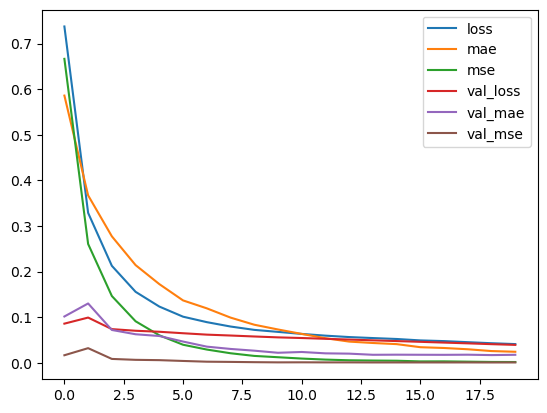

In [9]:
def train_and_evaluate(model, visualize=False):
    history = model.fit(X_train, y_train, batch_size = 20, epochs = 20, validation_split=0.4)
    if visualize:
        pd.DataFrame(history.history).plot()

train_and_evaluate(model, visualize=True)

## 2nd Model: Polynomial regression


R2 score on training data: 0.08603185678895542
R2 score on test data: 0.0906818324749582


<Axes: >

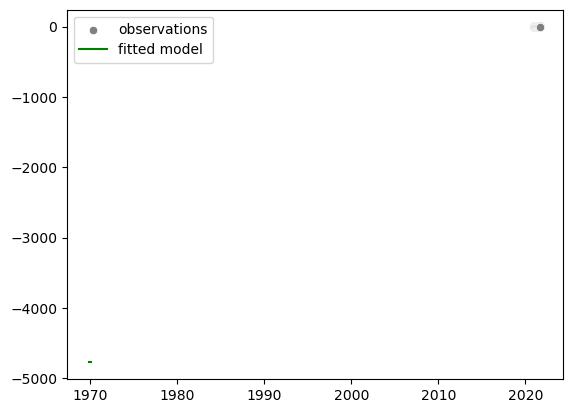

In [12]:

site2_charging_data = agg_charging_data[
    ['utilizationRate_site2', 'hour_of_day', 'day_of_week', 'month_of_year', 'kWhDelivered_site2',
     'activeSessions_site2']]


from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import seaborn as sns

# config
D = 5 # degree of polynomials
ALPHA = 0.1 # alpha (in lecture: lambda) for regularization penalty

X = agg_charging_data.index.values
y = agg_charging_data['utilizationRate_site2'].values

X_trainreg, X_testreg, y_trainreg, y_testreg = train_test_split(X, y, test_size = 0.3)
# reshape
X_trainreg, X_testreg = X_trainreg.reshape(-1,1), X_testreg.reshape(-1,1)


# compose pipeline
pipeline = Pipeline([
    ('polynomials', PolynomialFeatures(degree = D)), 
    ('ridge', Ridge(alpha = ALPHA))
])

# run both sets through the pipeline
pipeline.fit(X_trainreg, y_trainreg)

# predict train set for r^2 metric
pred = pipeline.predict(X_trainreg)
# predict test set
test_pred = pipeline.predict(X_testreg)

# report R^2 score (goodness of fit)
print(f'R2 score on training data: {r2_score(y_trainreg, pred)}')
print(f'R2 score on test data: {r2_score(y_testreg, test_pred)}')


# plot
fig, ax = plt.subplots()

# predict curve for plotting
x_plot = np.arange(-40, 30, 0.1)
y_plot = pipeline.predict(x_plot.reshape(-1,1))

sns.scatterplot(x=X, y=y, color = 'grey', label = 'observations', ax=ax)
sns.lineplot(x=x_plot, y=y_plot, color = 'green', label = 'fitted model', ax=ax)

## Performance evaluation and forecasting.